In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import csv

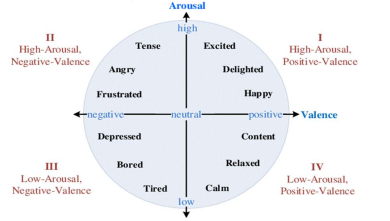

In [55]:
mood_names = [
    'Happy', 'Delighted', 'Excited',
    'Tense', 'Angry', 'Frustrated',
    'Depressed', 'Bored', 'Tired',
    'Calm', 'Relaxed', 'Content',
]
mood_count = len(mood_names)

We will use 2 variables to classify each song to corresponding mood.
We don't have Arousal, but we have energy column, so we can replace those as they represent similar thing.

To select other useful variables for our model we can read from [this](https://towardsdatascience.com/predicting-my-mood-using-my-spotify-data-2e898add122a) paper, that the acousticness
has the most impact on mood from the remaining variables.

In [56]:
data = pd.read_csv('tracks.csv')[['valence', 'energy', 'acousticness', 'song_name']]
data.head()

C:\Users\olafl\AppData\Local\Temp\ipykernel_24320\3415676746.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('tracks.csv')[['valence', 'energy', 'acousticness', 'song_name']]


,valence,energy,acousticness,song_name
0,0.3890,0.814,0.0598,Mercury: Retrograde
1,0.1240,0.493,0.4010,Pathology
2,0.0391,0.893,0.0138,Symbiote
3,0.1750,0.781,0.0237,ProductOfDrugs (Prod. The Virus and Antidote)
4,0.5910,0.624,0.2170,Venom


Spotify api pre-normalizes those values so we don't need to worry about it, but I will subtract 0.5 from valence and energy for easier plotting

In [57]:
data_classified = data.copy()
for i, row in data_classified.iterrows():
  data_classified.at[i, 'valence'] -= 0.5
  data_classified.at[i, 'energy'] -= 0.5

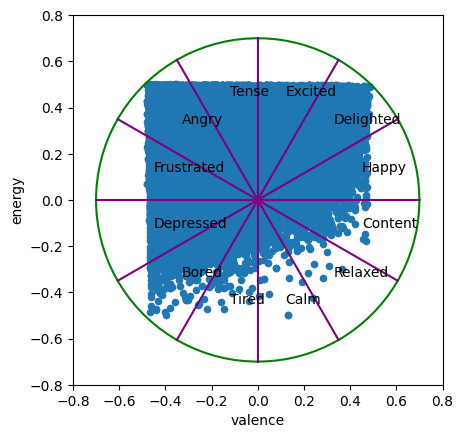

In [58]:
data_classified.plot(x='valence', y='energy', kind='scatter')

# Plot circle
r = 0.7 # arbitrarily bigger to fit all the data
plt.xlim(-(r+0.1), (r+0.1))
plt.ylim(-(r+0.1), (r+0.1))
plt.gca().set_aspect('equal')

angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
xs = r * np.cos(angles)
ys = r * np.sin(angles)
plt.plot(xs, ys, color = 'green')

# Plot boundaries and make list of areas of boundaries to classify songs
boundaries_dict = {}
for i in range(mood_count):
  plt.plot(
       [0, r * np.cos(i * np.pi/6)],
       [0, r * np.sin(i * np.pi/6)],
       color = "purple"
  )
  boundaries_dict[mood_names[i]] = [
      [0, 0],
      [r * np.cos(i * np.pi/6), r * np.sin(i * np.pi/6)],
      [r * np.cos((i+1) * np.pi/6), r * np.sin((i+1) * np.pi/6)]
  ]
  plt.gca().annotate(mood_names[i], xy=(r/1.5 * np.cos((i+0.5) * np.pi/6), r/1.5 * np.sin((i+0.5) * np.pi/6)), xycoords='data', fontsize=10, )

In [59]:
# classify songs
def point_in_triangle(p, v1, v2, v3):
    def _test(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    b1 = _test(p, v1, v2) < 0.0
    b2 = _test(p, v2, v3) < 0.0
    b3 = _test(p, v3, v1) < 0.0

    return (b1 == b2) and (b2 == b3)

data_classified['mood'] = None
for i, row in data_classified.iterrows():
    x, y = data_classified.at[i, 'valence'], data_classified.at[i, 'energy']

    for key, value in boundaries_dict.items():
      point=[x, y]
      if point_in_triangle(p=point, v1=value[0], v2=value[1], v3=value[2]):
        data_classified.at[i, 'mood'] = key
        continue

data_classified.head()

,valence,energy,acousticness,song_name,mood
0,-0.1110,0.314,0.0598,Mercury: Retrograde,Tense
1,-0.3760,-0.007,0.4010,Pathology,Depressed
2,-0.4609,0.393,0.0138,Symbiote,Angry
3,-0.3250,0.281,0.0237,ProductOfDrugs (Prod. The Virus and Antidote),Angry
4,0.0910,0.124,0.2170,Venom,Delighted


To not have bias towards any mood we need to equalize number of samples per each

([<matplotlib.axis.XTick at 0x2097d039690>,
 [Text(0, 0, 'Happy'),
  Text(1, 0, 'Delighted'),
  Text(2, 0, 'Excited'),
  Text(3, 0, 'Tense'),
  Text(4, 0, 'Angry'),
  Text(5, 0, 'Frustrated'),
  Text(6, 0, 'Depressed'),
  Text(7, 0, 'Bored'),
  Text(8, 0, 'Tired'),
  Text(9, 0, 'Calm'),
  Text(10, 0, 'Relaxed'),
  Text(11, 0, 'Content')])

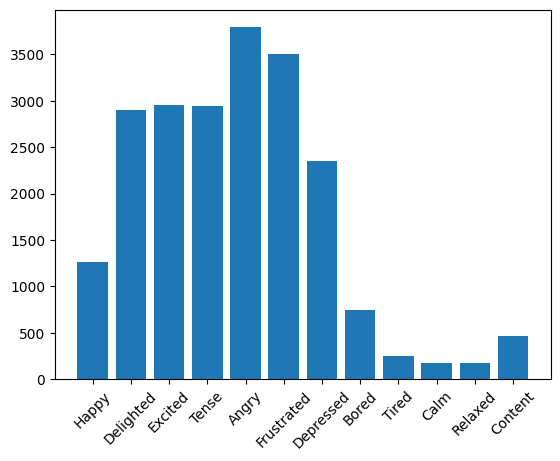

In [60]:
moods_count = {}
for mood in mood_names:
    moods_count[mood] = len(data_classified.where(data_classified['mood'] == mood).dropna())

plt.bar(range(len(moods_count)), list(moods_count.values()), align='center')
plt.xticks(np.arange(0, 12, step=1), mood_names, rotation = 45)

In [61]:
n_samples_per_mood = min(moods_count.values())

In [62]:
data_classified_equalized = pd.DataFrame()

for mood in mood_names:
    data_classified_equalized = pd.concat([
        data_classified_equalized,
        pd.DataFrame(data_classified.where(data_classified['mood'] == mood).dropna().sample(n=n_samples_per_mood))
    ])

data_classified_equalized.head()

,valence,energy,acousticness,song_name,mood
11252,0.253,0.126,0.02010,ME TOO,Happy
14413,0.347,0.121,0.24400,My Shit,Happy
19786,0.341,0.178,0.12100,JAPAN,Happy
9587,0.272,0.089,0.00015,Kicked Back,Happy
16546,0.296,0.051,0.00364,Love Like This,Happy


The data still won't be perfect as some of the moods have a lot more variance, but we have to deal with this

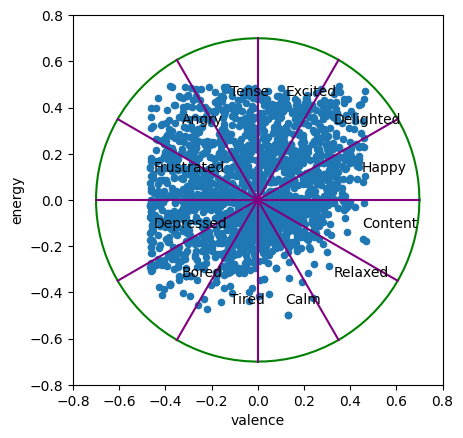

In [63]:
data_classified_equalized.plot(x='valence', y='energy', kind='scatter')

# Plot circle
r = 0.7 # arbitrarily bigger to fit all the data
plt.xlim(-(r+0.1), (r+0.1))
plt.ylim(-(r+0.1), (r+0.1))
plt.gca().set_aspect('equal')

angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
xs = r * np.cos(angles)
ys = r * np.sin(angles)
plt.plot(xs, ys, color = 'green')

# Plot boundaries and make list of areas of boundaries to classify songs
boundaries_dict = {}
for i in range(mood_count):
  plt.plot(
       [0, r * np.cos(i * np.pi/6)],
       [0, r * np.sin(i * np.pi/6)],
       color = "purple"
  )
  plt.gca().annotate(mood_names[i], xy=(r/1.5 * np.cos((i+0.5) * np.pi/6), r/1.5 * np.sin((i+0.5) * np.pi/6)), xycoords='data', fontsize=10, )

Now we have to split into train and test datasets (we don't have enough data for validation set)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    data_classified_equalized[['valence', 'energy', 'acousticness']], data_classified_equalized['mood'],
    test_size=0.2, random_state=42
)
X_train

,valence,energy,acousticness
10327,0.2150,0.012,0.27400
194,-0.0180,0.074,0.01210
13461,-0.1790,-0.314,0.86800
9188,0.3640,0.028,0.47100
18626,0.3420,0.374,0.01730
...,...,...,...
5471,0.0460,-0.271,0.29400
14345,-0.3770,-0.128,0.01300
9222,-0.4608,-0.079,0.65000
2891,-0.4594,-0.304,0.58400


In [66]:
y_train

10327        Happy
194          Tense
13461        Tired
9188         Happy
18626    Delighted
           ...    
5471          Calm
14345    Depressed
9222     Depressed
2891         Bored
9800         Angry
Name: mood, Length: 1670, dtype: object

Now we just need to save data to csv for model to train on

In [71]:
data_classified_equalized.to_csv('data_classified_equalized.csv')
X_train.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")